In [ ]:
# Introduction

#This project is part of the Coursera Capstone project and will utilise Foursquare API for venue information of Tokyo 
#for analysis on the restaurants located in Tokyo.

In [ ]:
# Data used
# A table from https://en.wikipedia.org/wiki/Special_wards_of_Tokyo will be used for the location data
# Foursquare will be used for venue data

In [1]:
# import the necessary Libraries 
import sys
import requests
import json

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


import io
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
! pip install folium

     |████████████████████████████████| 92kB 15.1MB/s eta 0:00:01


In [2]:
response_obj = requests.get('https://en.wikipedia.org/wiki/Special_wards_of_Tokyo').text
soup = BeautifulSoup(response_obj,'lxml')
Wards_Tokyo_Table = soup.find('table', {'class':'wikitable sortable'})
### preparation of the table 

Name=[]
Kanji = []
Pop = []
Density = []
num = []
flag = []
Area = []
Major_District = []

for row in Wards_Tokyo_Table.findAll("tr"):
    #print (row)    
    Ward = row.findAll('td')
    #print (len(Ward))
    print (Ward)
    if len(Ward)==8: #Only extract table body not heading
        print (Ward[0])
        #print postcode[1]
        #print postcode[2]
        num.append(Ward[0].find(text=True))
        flag.append(Ward[1].findAll('a')) # useless
        Name.append(Ward[2])
        Kanji.append(Ward[3].find(text=True))
        Pop.append(Ward[4])
        Area.append(Ward[5].find(text=True))
        Major_District.append(Ward[7].find(text=True))
            
#print (Pop) 


#++++++++++++++++++++++++++++++++++++++++++++++
#+ Area 
#++++++++++++++++++++++++++++++++++++++++++++++

# print (Area[3]) # the first element of the area needs a replacement with the true value 5100
Area = ['5100' if x=='0' else x for x in Area]
New_Area = []

# change the type of Area list 
for l in range(len(Area)):
    x=Area[l].replace(",","")
    print (x)
    New_Area.append(x)

New_Area=[int(s) for s in New_Area]

#print (New_Area) # the list elements are already in accordance with the table

#+++++++++++++++++++++++++++++++++++++++++++++++++++++
#+ Name of the Wards
#+++++++++++++++++++++++++++++++++++++++++++++++++++++
#print (Name) # want to select only the title part

new_names = []
for n in range(len(Name)):
    print (Name[n])
    names = Name[n].findAll('a')
    new_names.append(names) 

print (new_names)

flat_new_names_list = [item for sublist in new_names for item in sublist]
print (flat_new_names_list)

Wards_names= []
#now 
for name_wards in flat_new_names_list:
        Wards_names.append(name_wards.get('title'))

print (Wards_names)

# replace the elements in the list that contains 'Tokyo' with only the ward names
replace_names={'Chiyoda, Tokyo':'Chiyoda', 'Chūō, Tokyo':'Chuo', 'Minato, Tokyo':'Minato', 
               'Sumida, Tokyo':'Sumida', 'Koto, Tokyo':'Koto', 'Ōta, Tokyo':'Ota', 'Nakano, Tokyo':'Nakano', 
               'Kita, Tokyo':'Kita', 'Arakawa, Tokyo':'Arakawa', 'Adachi, Tokyo':'Adachi', 'Edogawa, Tokyo':'Edogawa'}


Wards_names1 = [replace_names.get(n1,n1) for n1 in Wards_names]

#print (Wards_names1)

#+++++++++++++++++++++++++++++++++++++++++++++++++++++
#+ Population
#+++++++++++++++++++++++++++++++++++++++++++++++++++++
# print (len(Pop))
# #print ((Pop[5].text))
population = []
for p in range(len(Pop)):
    print ((Pop[p]))
    pops = Pop[p].text[1:9]
    print (Pop[p].text[1:9])
    #populs = Pop[p].find('visibility:hidden;color:transparent;')
    population.append(pops) 
print (population)


New_population = []
for po in range(len(population)):
    xy=population[po].replace(",","")
    print (xy)
    New_population.append(xy)

New_population=[int(s1) for s1 in New_population]
# print (New_population)



#++++++++++++++++++++++++++++++++++++++++++++++++
#+ Major Districts
#++++++++++++++++++++++++++++++++++++++++++++++++


replace_districts = {'Nagatachō':'Nagatacho', 'Hongō':'Hongo', 'Kinshichō':'Kinshicho', 'Ōmori': 'Omori', 
                     'Kōenji':'Koenji', 'Arakawa, Machiya, ':'Arakawa', 'Ayase, ':'Ayase', 'Kasai, Koiwa\n':'Kasai'}


Major_District_names1 = [replace_districts.get(n2,n2) for n2 in Major_District]


df=pd.DataFrame(Wards_names1,columns=['Ward'])
df['Area_SqKm'] = New_Area
df['Population'] = New_population
df['Major_District'] = Major_District_names1
df.index = np.arange(1, len(df) + 1) # reset the index so that it starts from 1. 

# use of geopy geocoders
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Tokyo_explorer")
df['Major_Dist_Coord']= df['Major_District'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df[['Latitude', 'Longitude']] = df['Major_Dist_Coord'].apply(pd.Series)

df.drop(['Major_Dist_Coord'], axis=1, inplace=True)
# replace some of the wrong coordinates 


Lat_list = df['Latitude'].tolist()
Long_list = df['Longitude'].tolist()
print ("Old latitude list: ", Lat_list)
print ("Old Longitude list: ", Long_list)
replace_latitudes = {32.5093796:35.7088, 23.0131338:35.6722, -38.9047057:35.5884, -5.3498001:35.6634}
replace_longitudes = {-116.2970014:139.7601, -80.8328748:139.8061, 175.7552111:139.7279, 21.424098:139.8731}

latitudes_new = [replace_latitudes.get(n3,n3) for n3 in Lat_list]
longtitudes_new = [replace_longitudes.get(n4,n4) for n4 in Long_list]
print (latitudes_new)
print (longtitudes_new)

Tokyo_df = df.drop(['Latitude', 'Longitude'], axis=1)
# #df.drop(['Longitude'], axis=1, inplace=True)
# Tokyo_df


Tokyo_df['Dist_Latitude'] = latitudes_new
Tokyo_df['Dist_Longitude'] = longtitudes_new

Tokyo_df.to_csv('Tokyo_df_Coord.csv')

[]
[<td>01</td>, <td><a class="image" href="/wiki/File:Flag_of_Chiyoda,_Tokyo.svg"><img alt="Flag of Chiyoda, Tokyo.svg" class="thumbborder" data-file-height="540" data-file-width="810" decoding="async" height="33" src="//upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Flag_of_Chiyoda%2C_Tokyo.svg/50px-Flag_of_Chiyoda%2C_Tokyo.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Flag_of_Chiyoda%2C_Tokyo.svg/75px-Flag_of_Chiyoda%2C_Tokyo.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Flag_of_Chiyoda%2C_Tokyo.svg/100px-Flag_of_Chiyoda%2C_Tokyo.svg.png 2x" width="50"/></a></td>, <td><a href="/wiki/Chiyoda,_Tokyo" title="Chiyoda, Tokyo">Chiyoda</a></td>, <td>千代田区
</td>, <td><span style="visibility:hidden;color:transparent;">0</span><span style="visibility:hidden;color:transparent;">0</span>59,441</td>, <td><span style="visibility:hidden;color:transparent;">0</span>5,100</td>, <td><span style="visibility:hidden;color:transparent;">0</span>11.66
</td>, <t

In [3]:
Tokyo_df = pd.read_csv('Tokyo_df_Coord.csv', index_col=[0])
#remove the unnamed column 
Tokyo_df

,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude
1,Chiyoda,5100,59441,Nagatacho,35.675618,139.743469
2,Chuo,14460,147620,Nihonbashi,35.684058,139.774501
3,Minato,12180,248071,Odaiba,35.626722,139.772101
4,Shinjuku,18620,339211,Shinjuku,35.693763,139.703632
5,Bunkyō,19790,223389,Hongo,35.175386,137.013430
6,Taitō,19830,200486,Ueno,35.711759,139.777645
7,Sumida,18910,260358,Kinshicho,35.696312,139.815043
8,Koto,12510,502579,Kiba,35.672200,139.806100
9,Shinagawa,17180,392492,Shinagawa,35.599252,139.738910
10,Meguro,19110,280283,Meguro,35.621250,139.688014


In [4]:
# Define Foursquare credentials
CLIENT_ID = 'YKAME4ZKBBUU0OOOGI3HRC20Q2HEGKYAAWAMOKBWRUJTWRET' # your Foursquare ID
CLIENT_SECRET = '54IY0VUE5BUZ2LOQB0WGGCMEPSM52AOSJFNJEIPPZQAT1YX0' # your Foursquare Secret
VERSION = '20200220' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YKAME4ZKBBUU0OOOGI3HRC20Q2HEGKYAAWAMOKBWRUJTWRET
CLIENT_SECRET:54IY0VUE5BUZ2LOQB0WGGCMEPSM52AOSJFNJEIPPZQAT1YX0


In [7]:
radius = 1000
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Dist_Latitude', 
                  'Dist_Longitude', 
                  'Venue', 
                  'Venue_Lat', 
                  'Venue_Long', 
                  'Venue_Category']
    
    return(nearby_venues)

In [8]:
Tokyo_Venues = getNearbyVenues(names=Tokyo_df['Major_District'],
                                   latitudes=Tokyo_df['Dist_Latitude'],
                                   longitudes=Tokyo_df['Dist_Longitude']
                                  )

Nagatacho
Nihonbashi
Odaiba
Shinjuku
Hongo
Ueno
Kinshicho
Kiba
Shinagawa
Meguro
Omori
Setagaya
Shibuya
Nakano
Koenji
Ikebukuro
Akabane
Arakawa
Itabashi
Nerima
Ayase
Tateishi
Kasai


In [9]:
print ("Shape of the Venues Dataframe: ", Tokyo_Venues.shape)
Tokyo_Venues.tail(3)

Shape of the Venues Dataframe:  (2045, 7)


,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
2042,Kasai,35.6634,139.8731,お好み焼き バブ,35.661929,139.876280,Japanese Restaurant
2043,Kasai,35.6634,139.8731,Nakacho Park (仲町公園),35.660702,139.875569,Park
2044,Kasai,35.6634,139.8731,中華料理 正ちゃん,35.666409,139.875290,Chinese Restaurant


In [10]:
# Create a Data-Frame out of it to Concentrate Only on Restaurants 

Tokyo_restaurant = Tokyo_Venues[Tokyo_Venues['Venue_Category']\
                                                          .str.contains('Restaurant')].reset_index(drop=True)
Tokyo_restaurant.index = np.arange(1, len(Tokyo_restaurant)+1)
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", Tokyo_restaurant.shape)
Tokyo_restaurant.head(3)

Shape of the Data-Frame with Venue Category only Restaurant:  (657, 7)


,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
1,Nagatacho,35.675618,139.743469,Nagatacho Kurosawa (永田町 黒澤),35.674699,139.741737,Japanese Restaurant
2,Nagatacho,35.675618,139.743469,Shinamen Hashigo (支那麺 はしご),35.672184,139.741576,Ramen Restaurant
3,Nagatacho,35.675618,139.743469,Sushi Isshin (鮨 一新),35.672589,139.739399,Sushi Restaurant


In [11]:
# get Tokyo, Tokyo Latitude and Longitude 

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Tokyo'

geolocator = Nominatim(user_agent="Tokyo_explorer")
location = geolocator.geocode(address)
Tokyo_latitude = location.latitude
Tokyo_longitude = location.longitude
print('The geograpical coordinates of Tokyo are {}, {}.'.format(Tokyo_latitude, Tokyo_longitude))

The geograpical coordinates of Tokyo are 35.6828387, 139.7594549.


In [13]:
## Show in Map the Top Rated Restaruants in the Top 5 Districts
import folium
map_restaurants = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], zoom_start=11, tiles="openstreetmap", 
                            attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the Venues based on the Major Districts
Districts = Tokyo_df['Major_District']
DD = Districts.values.tolist()
DD

['Nagatacho',
 'Nihonbashi',
 'Odaiba',
 'Shinjuku',
 'Hongo',
 'Ueno',
 'Kinshicho',
 'Kiba',
 'Shinagawa',
 'Meguro',
 'Omori',
 'Setagaya',
 'Shibuya',
 'Nakano',
 'Koenji',
 'Ikebukuro',
 'Akabane',
 'Arakawa',
 'Itabashi',
 'Nerima',
 'Ayase',
 'Tateishi',
 'Kasai']

In [14]:

x = np.arange(len(DD))

rainbow = ['#00ff00', '#ff00ff','#0000ff','#ffa500' ,'#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000']

# add markers to the map
# markers_colors = []
for lat, lon, poi, distr in zip(Tokyo_restaurant['Venue_Lat'], 
                                  Tokyo_restaurant['Venue_Long'], 
                                  Tokyo_restaurant['Venue_Category'], 
                                  Tokyo_restaurant['District']):
    label = folium.Popup(str(poi) + ' ' + str(distr), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[DD.index(distr)-1],
        fill=True,
        fill_color=rainbow[DD.index(distr)-1],
        fill_opacity=0.3).add_to(map_restaurants)
       
map_restaurants

In [16]:
### Number of Unique Categories in the Dataframe 
print('There are {} unique categories.'.format(len(Tokyo_Venues['Venue_Category'].unique())))
## We can check some of the categories randomly  
print (Tokyo_Venues[['Venue_Category']][70:75])

There are 230 unique categories.
         Venue_Category
70           Steakhouse
71            BBQ Joint
72  Japanese Restaurant
73  American Restaurant
74          Supermarket


In [17]:
print (Tokyo_Venues['Venue_Category'].value_counts())

Convenience Store            199
Ramen Restaurant             108
Sake Bar                     102
Japanese Restaurant           90
Café                          80
BBQ Joint                     66
Coffee Shop                   58
Chinese Restaurant            54
Italian Restaurant            48
Park                          46
Grocery Store                 43
Sushi Restaurant              33
Bar                           31
Soba Restaurant               29
Bakery                        26
Steakhouse                    26
Hotel                         23
Dessert Shop                  23
Supermarket                   22
Indian Restaurant             22
Intersection                  22
Discount Store                21
Restaurant                    20
Yoshoku Restaurant            17
Seafood Restaurant            17
Donburi Restaurant            16
Shopping Mall                 16
Yakitori Restaurant           16
Record Shop                   14
Japanese Curry Restaurant     14
          

In [18]:
# create a dataframe of top 10 categories
Tokyo_Venues_Top10 = Tokyo_Venues['Venue_Category'].value_counts()[0:10].to_frame(name='frequency')
Tokyo_Venues_Top10=Tokyo_Venues_Top10.reset_index()
#Tokyo_5_Dist_Venues_Top10

Tokyo_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
Tokyo_Venues_Top10

,Venue_Category,Frequency
0,Convenience Store,199
1,Ramen Restaurant,108
2,Sake Bar,102
3,Japanese Restaurant,90
4,Café,80
5,BBQ Joint,66
6,Coffee Shop,58
7,Chinese Restaurant,54
8,Italian Restaurant,48
9,Park,46


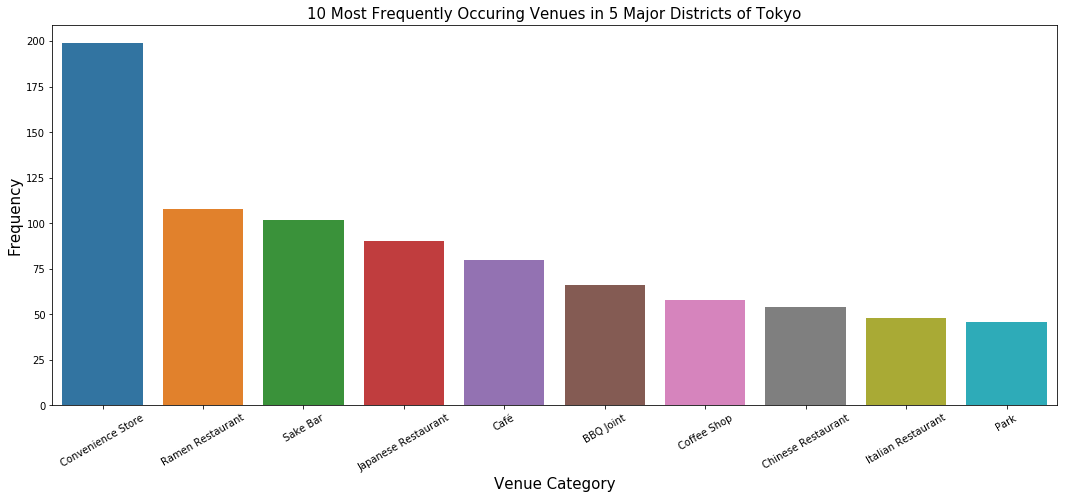

In [19]:
import seaborn as sns
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue_Category", y="Frequency", data=Tokyo_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Frequently Occuring Venues in 5 Major Districts of Tokyo', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

In [22]:
### Use One Hot Encoding to Get More Information about the Venue Categories 
Tokyo_Venues_onehot = pd.get_dummies(Tokyo_Venues[['Venue_Category']], prefix="", prefix_sep="")

### add district column back to dataframe
Tokyo_Venues_onehot['District'] = Tokyo_Venues['District'] 
### move district column to the first column
fixed_columns = [Tokyo_Venues_onehot.columns[-1]] + list(Tokyo_Venues_onehot.columns[:-1])
Tokyo_Venues_onehot = Tokyo_Venues_onehot[fixed_columns]
Tokyo_Venues_onehot.head(3)

Tokyo_Venues_Grouped = Tokyo_Venues_onehot.groupby('District').mean().reset_index()
Tokyo_Venues_Grouped.index = np.arange(1, len(Tokyo_Venues_Grouped)+1)
Tokyo_Venues_Grouped

,District,ATM,Accessories Store,African Restaurant,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Unagi Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wagashi Place,Wine Bar,Wings Joint,Yakitori Restaurant,Yoshoku Restaurant
1,Akabane,0.010000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,...,0.010000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.01,0.00
2,Arakawa,0.000000,0.00,0.00,0.00,0.00,0.00,0.010638,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00
3,Ayase,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00
4,Hongo,0.016949,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,...,0.016949,0.00,0.00,0.016949,0.00,0.000000,0.000000,0.016949,0.00,0.00
5,Ikebukuro,0.000000,0.00,0.00,0.00,0.00,0.01,0.000000,0.000000,0.00,...,0.010000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.06
6,Itabashi,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00
7,Kasai,0.000000,0.00,0.00,0.00,0.00,0.01,0.000000,0.000000,0.00,...,0.000000,0.01,0.00,0.010000,0.00,0.000000,0.000000,0.000000,0.00,0.00
8,Kiba,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.010309,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.010309,0.010309,0.000000,0.00,0.00
9,Kinshicho,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,...,0.010000,0.00,0.00,0.000000,0.01,0.010000,0.000000,0.000000,0.01,0.01
10,Koenji,0.000000,0.00,0.00,0.01,0.00,0.01,0.000000,0.000000,0.00,...,0.000000,0.00,0.01,0.000000,0.01,0.000000,0.000000,0.000000,0.02,0.01


In [25]:
## Define a Function to select the top 10 rows (According to the Values) 

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:top_venues]

top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
District_top10_venues_sorted = pd.DataFrame(columns=columns)
District_top10_venues_sorted['District'] = Tokyo_Venues_Grouped['District']

for ind in np.arange(Tokyo_Venues_Grouped.shape[0]):
    District_top10_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Tokyo_Venues_Grouped.iloc[ind, :], top_venues)

    
District_top10_venues_sorted.index = np.arange(1, len(District_top10_venues_sorted)+1)
District_top10_venues_sorted.head(5)

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Akabane,Sake Bar,Convenience Store,Ramen Restaurant,Italian Restaurant,Supermarket,BBQ Joint,Bar,Coffee Shop,Soba Restaurant,Discount Store
2,Arakawa,Convenience Store,Chinese Restaurant,Deli / Bodega,Grocery Store,Tram Station,Japanese Restaurant,Donburi Restaurant,Italian Restaurant,Park,Noodle House
3,Ayase,Convenience Store,Japanese Restaurant,Clothing Store,Restaurant,Italian Restaurant,Mobile Phone Shop,Auto Garage,Sushi Restaurant,Department Store,Steakhouse
4,Hongo,Convenience Store,Intersection,Ramen Restaurant,Japanese Restaurant,Café,Sake Bar,Dessert Shop,Toll Booth,Japanese Curry Restaurant,Fried Chicken Joint
5,Ikebukuro,Sake Bar,Café,Japanese Restaurant,Ramen Restaurant,Yoshoku Restaurant,Chinese Restaurant,Dessert Shop,Coffee Shop,Sushi Restaurant,Italian Restaurant


In [44]:
# set number of clusters
kclusters = 5

Tokyo_grouped_clustering = Tokyo_Venues_Grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Tokyo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print ("Check the 5 Cluster labels :",  kmeans.labels_[0:5])

Check the 5 Cluster labels : [3 1 3 4 0]


In [45]:
# add clustering labels

#District_top10_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

Tokyo_Coordinate_Cluster_merged = Tokyo_df

#merge the inital Tokyo Dataframe with Sorted Most Visited places for each neighborhood

Tokyo_Coordinate_Cluster_merged = Tokyo_Coordinate_Cluster_merged.join \
                                        (District_top10_venues_sorted.set_index('District'), on='Major_District')

Tokyo_Coordinate_Cluster_merged.head()

,Ward,Area_SqKm,Population,Major_District,Dist_Latitude,Dist_Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chiyoda,5100,59441,Nagatacho,35.675618,139.743469,0,Japanese Restaurant,BBQ Joint,Coffee Shop,Ramen Restaurant,Hotel,Chinese Restaurant,Szechuan Restaurant,Bar,Dessert Shop,Yakitori Restaurant
2,Chuo,14460,147620,Nihonbashi,35.684058,139.774501,0,Japanese Restaurant,BBQ Joint,Soba Restaurant,Café,Chinese Restaurant,Hobby Shop,Hotel,Department Store,Bakery,Gift Shop
3,Minato,12180,248071,Odaiba,35.626722,139.772101,0,Italian Restaurant,Plaza,Theme Park,Exhibit,Coffee Shop,American Restaurant,Convenience Store,Park,Shopping Mall,Discount Store
4,Shinjuku,18620,339211,Shinjuku,35.693763,139.703632,0,Bar,Sake Bar,Ramen Restaurant,Japanese Restaurant,BBQ Joint,Pub,Garden,Record Shop,Thai Restaurant,Soba Restaurant
5,Bunkyō,19790,223389,Hongo,35.175386,137.013430,4,Convenience Store,Intersection,Ramen Restaurant,Japanese Restaurant,Café,Sake Bar,Dessert Shop,Toll Booth,Japanese Curry Restaurant,Fried Chicken Joint


In [46]:
# create map
map_restaurants10 = folium.Map(location=[Tokyo_latitude, Tokyo_longitude], tiles='cartodbpositron', 
                               attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
Districts = Tokyo_df['Major_District']
DD = Districts.values.tolist()
DD

Tokyo_Venues_restaurant = Tokyo_Venues.groupby(['District'])['Venue_Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())
Tokyo_Venues_restaurant_df = Tokyo_Venues_restaurant.to_frame().reset_index()
Tokyo_Venues_restaurant_df.columns = ['District', 'Number of Restaurant']
list_rest_no = Tokyo_Venues_restaurant_df['Number of Restaurant'].to_list()

# add markers to the map
for lat, lon, poi, cluster in zip(Tokyo_Coordinate_Cluster_merged['Dist_Latitude'], 
                                  Tokyo_Coordinate_Cluster_merged['Dist_Longitude'], 
                                  Tokyo_Coordinate_Cluster_merged['Major_District'], 
                                  Tokyo_Coordinate_Cluster_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=list_rest_no[DD.index(poi)]*0.5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_restaurants10)
       
map_restaurants10

In [36]:
Tokyo_Cluster1 = Tokyo_Coordinate_Cluster_merged.loc[Tokyo_Coordinate_Cluster_merged['Cluster Label'] == 0, 
                                    Tokyo_Coordinate_Cluster_merged.columns[[3] + list(range(4, Tokyo_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 0: %d" %(Tokyo_Cluster1.shape[0]))
Tokyo_Cluster1

No of Neighbourhood in Cluster Label 0: 10


,Major_District,Dist_Latitude,Dist_Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Nagatacho,35.675618,139.743469,0,Japanese Restaurant,BBQ Joint,Coffee Shop,Ramen Restaurant,Hotel,Chinese Restaurant,Szechuan Restaurant,Bar,Dessert Shop,Yakitori Restaurant
2,Nihonbashi,35.684058,139.774501,0,Japanese Restaurant,BBQ Joint,Soba Restaurant,Café,Chinese Restaurant,Hobby Shop,Hotel,Department Store,Bakery,Gift Shop
3,Odaiba,35.626722,139.772101,0,Italian Restaurant,Plaza,Theme Park,Exhibit,Coffee Shop,American Restaurant,Convenience Store,Park,Shopping Mall,Discount Store
4,Shinjuku,35.693763,139.703632,0,Bar,Sake Bar,Ramen Restaurant,Japanese Restaurant,BBQ Joint,Pub,Garden,Record Shop,Thai Restaurant,Soba Restaurant
6,Ueno,35.711759,139.777645,0,Sake Bar,BBQ Joint,Japanese Restaurant,Chinese Restaurant,Café,Ramen Restaurant,Science Museum,Tonkatsu Restaurant,Coffee Shop,Cocktail Bar
7,Kinshicho,35.696312,139.815043,0,Ramen Restaurant,Sake Bar,Coffee Shop,Pub,Chinese Restaurant,Thai Restaurant,Hotel,Japanese Restaurant,Sushi Restaurant,Indian Restaurant
11,Omori,35.588473,139.727933,0,Sake Bar,Coffee Shop,Japanese Restaurant,Soba Restaurant,Discount Store,Convenience Store,Ramen Restaurant,BBQ Joint,Café,Supermarket
13,Shibuya,35.664596,139.698711,0,Café,Record Shop,Coffee Shop,French Restaurant,Seafood Restaurant,Chinese Restaurant,Sushi Restaurant,Ramen Restaurant,Bookstore,Bar
15,Koenji,35.704942,139.649909,0,Café,Sake Bar,Ramen Restaurant,BBQ Joint,Italian Restaurant,Bar,Chinese Restaurant,Bookstore,Indian Restaurant,Beer Bar
16,Ikebukuro,35.730103,139.711884,0,Sake Bar,Café,Japanese Restaurant,Ramen Restaurant,Yoshoku Restaurant,Chinese Restaurant,Dessert Shop,Coffee Shop,Sushi Restaurant,Italian Restaurant


In [37]:
Tokyo_Cluster2 = Tokyo_Coordinate_Cluster_merged.loc[Tokyo_Coordinate_Cluster_merged['Cluster Label'] == 1, 
                                    Tokyo_Coordinate_Cluster_merged.columns[[3] + list(range(4, Tokyo_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 0: %d" %(Tokyo_Cluster2.shape[0]))
Tokyo_Cluster2

No of Neighbourhood in Cluster Label 0: 3


,Major_District,Dist_Latitude,Dist_Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Arakawa,35.737529,139.781310,1,Convenience Store,Chinese Restaurant,Deli / Bodega,Grocery Store,Tram Station,Japanese Restaurant,Donburi Restaurant,Italian Restaurant,Park,Noodle House
19,Itabashi,35.774143,139.681209,1,Convenience Store,Bus Stop,Park,Grocery Store,Chinese Restaurant,Supermarket,Intersection,Liquor Store,Shopping Mall,Japanese Restaurant
23,Kasai,35.663400,139.873100,1,Convenience Store,Ramen Restaurant,Grocery Store,Steakhouse,Fast Food Restaurant,Indian Restaurant,Japanese Restaurant,BBQ Joint,Restaurant,Sushi Restaurant


In [38]:
Tokyo_Cluster3 = Tokyo_Coordinate_Cluster_merged.loc[Tokyo_Coordinate_Cluster_merged['Cluster Label'] == 2, 
                                    Tokyo_Coordinate_Cluster_merged.columns[[3] + list(range(4, Tokyo_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 0: %d" %(Tokyo_Cluster3.shape[0]))
Tokyo_Cluster3

No of Neighbourhood in Cluster Label 0: 1


,Major_District,Dist_Latitude,Dist_Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Tateishi,33.481791,131.478154,2,Intersection,Italian Restaurant,Farmers Market,Train Station,Yoshoku Restaurant,Exhibit,Food Court,Food & Drink Shop,Flower Shop,Flea Market


In [39]:
Tokyo_Cluster4 = Tokyo_Coordinate_Cluster_merged.loc[Tokyo_Coordinate_Cluster_merged['Cluster Label'] == 3, 
                                    Tokyo_Coordinate_Cluster_merged.columns[[3] + list(range(4, Tokyo_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 0: %d" %(Tokyo_Cluster4.shape[0]))
Tokyo_Cluster4

No of Neighbourhood in Cluster Label 0: 7


,Major_District,Dist_Latitude,Dist_Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Kiba,35.672200,139.806100,3,Convenience Store,Ramen Restaurant,Coffee Shop,Japanese Restaurant,Steakhouse,BBQ Joint,Park,Sake Bar,Gym / Fitness Center,Dessert Shop
9,Shinagawa,35.599252,139.738910,3,Convenience Store,Ramen Restaurant,BBQ Joint,Grocery Store,Sake Bar,Park,Sushi Restaurant,Restaurant,Yakitori Restaurant,Furniture / Home Store
10,Meguro,35.621250,139.688014,3,Convenience Store,Café,Coffee Shop,Japanese Restaurant,Grocery Store,Chinese Restaurant,Park,Ramen Restaurant,Bakery,Sake Bar
12,Setagaya,35.646096,139.656270,3,Convenience Store,Japanese Restaurant,Bakery,Sake Bar,Italian Restaurant,Café,Tram Station,Kushikatsu Restaurant,Ramen Restaurant,Grocery Store
14,Nakano,35.718123,139.664468,3,Convenience Store,Ramen Restaurant,Sake Bar,Italian Restaurant,Café,Park,BBQ Joint,Japanese Curry Restaurant,Grocery Store,Seafood Restaurant
17,Akabane,35.778139,139.720800,3,Sake Bar,Convenience Store,Ramen Restaurant,Italian Restaurant,Supermarket,BBQ Joint,Bar,Coffee Shop,Soba Restaurant,Discount Store
21,Ayase,35.446047,139.430823,3,Convenience Store,Japanese Restaurant,Clothing Store,Restaurant,Italian Restaurant,Mobile Phone Shop,Auto Garage,Sushi Restaurant,Department Store,Steakhouse


In [40]:
Tokyo_Cluster5 = Tokyo_Coordinate_Cluster_merged.loc[Tokyo_Coordinate_Cluster_merged['Cluster Label'] == 4, 
                                    Tokyo_Coordinate_Cluster_merged.columns[[3] + list(range(4, Tokyo_Coordinate_Cluster_merged.shape[1]))]]
print ("No of Neighbourhood in Cluster Label 0: %d" %(Tokyo_Cluster5.shape[0]))
Tokyo_Cluster5

No of Neighbourhood in Cluster Label 0: 2


,Major_District,Dist_Latitude,Dist_Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Hongo,35.175386,137.013430,4,Convenience Store,Intersection,Ramen Restaurant,Japanese Restaurant,Café,Sake Bar,Dessert Shop,Toll Booth,Japanese Curry Restaurant,Fried Chicken Joint
20,Nerima,35.748360,139.638735,4,Convenience Store,Park,Intersection,Grocery Store,Café,Chinese Restaurant,Fast Food Restaurant,Bakery,Theme Park Ride / Attraction,Italian Restaurant
